In [1]:
%load_ext autoreload
%autoreload 2

# Generating samples and parsing parameters scan file



In [2]:
from GENE_ML.gene_ml.samplers.uniform import Uniform
from GENE_ML.gene_ml.executors.ScanExecutor import ScanExecutor
from GENE_ML.gene_ml.runners.GENErunner import GENErunner
from GENE_ML.gene_ml.parsers.GENEparser import GENE_scan_parser

import os
import sys
sys.path.append(os.path.join(os.getcwd(),'GENE_ML','enchanted-surrogates','src'))


parameters = ['box-kymin', '_grp_species_1-omt', '_grp_species_0-omt', 'species-omn', 'geometry-q0', 'geometry-shat', 'general-beta']
bounds = [(0.05,1), (10,70), (10,70), (5,60), (3,6), (0.001,4), (0.1E-2,0.4E-2)]

#Working fine
# parameters = ['box-kymin', '_grp_species_1-omt', 'species-omn']
# bounds = [(0.05,1), (10,70), (5,60)]

num_samples = 5000
sampler = Uniform(parameters=parameters, bounds=bounds, num_samples=num_samples)

##Parser
#The parsers main function is write_input_file
# wite_input_file takes a parameters file from base_params_path and a set of points in the form of a dict {param1:[point1,point2...], param2:[point1,point2...]...} 
#  It will then create a parameters file that can scan over all the points.
base_params_path = os.path.join(os.getcwd(),'parameters_base_dp')
remote_save_dir='/scratch/project_462000451/gene_out/gene_auto/5000s_7p'
parser = GENE_scan_parser(base_params_path, remote_save_dir)

## Runner
#The Runner is responsible for actually running a parameters file on lumi. Its main function is code_run.
# code_run will take the set of points named samples and parse them into a parameters file.
#  It then uses ssh to run GENE with this parametres file and a passed sbatch script.
remote_run_dir = '/project/project_462000451/gene_auto/'
host = 'lumi' #needs to be configured in /home/<user>/.ssh/config
sbatch_base_path = os.path.join('sbatch_base_dp')
guess_sample_wallseconds = 81 # a guess for the number of seconds it takes to run one sample.
runner = GENErunner(parser, remote_run_dir, host, sbatch_base_path, guess_sample_wallseconds)

##Executor
#The executor will divide the samples into batches; one for each worker. Each batch will be ran in paralell in seperate sbatch jobs. 
# The executor should alter a base batch script to account for that less samples will be ran. 
num_workers = 20
executor = ScanExecutor(num_workers, sampler, runner)
# if project == 'UQ':
#     #UQ
#     ##Sampler args dependant on sampler chosen
#     parameters = ['box-kymin', '_grp_species_0-omt', '_grp_species_1-omt']
#     bounds = [(0.1,100.0),(2,3.5), (4,6.75)]
#     ##Parser args
#     base_params_path = os.path.join(os.getcwd(),'parameters_base_uq')


#Sampling the data

In [3]:
# executor.start_runs()

# Pulling Scanlog from Lumi 

In [7]:
from GENE_ML.gene_ml.dataset.ScanData import ScanData
import os
host = 'lumi'
data_name = '5000s_7p'
test_percentage = 50

if os.path.isdir(f'scanlogs/{data_name}'):
    ## If the data is already loaded from the remote to local .../scanlogs/<data_name> then the host and remote path can be ommitted
    data_set = ScanData(data_name, parser, test_percentage=test_percentage)
else:
    data_set = ScanData(data_name, parser, host, remote_path=remote_save_dir, test_percentage=test_percentage)

Initialising dataset
MAKING SCANLOG DIR

RETRIEVING SCANLOG/S VIA scp FROM REMOTE
SCANLOG PATH: lumi:/scratch/project_462000451/gene_out/gene_auto/5000s_7p
RETRIVING FROM REMOTE DIR
THE ABOVE ERROR IS EXPECTED
SCANLOG/S RETRIEVED AND SAVED TO:/home/djdaniel/DEEPlasma/scanlogs/5000s_7p

LOADING SCANLOG/S


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___6.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___15.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___18.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___5.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___8.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___9.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___11.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___10.log


L

scp: /scratch/project_462000451/gene_out/gene_auto/5000s_7p/scanfiles*21/scan.log: No such file or directory


# Making Surrogate Model and Visualising Performance

# SVM

In [8]:

#imports
from GENE_ML.gene_ml.models.SVM import SVM


#Sampling already done, gene has been ran
#data_set = ScanData(name='100_3p', test_percentage=3)
svm = SVM()
svm.train(data_set.x_train, data_set.growthrate_train)

growthrate_predict_seen = svm.predict(data_set.x_train)
growthrate_predict_unseen = svm.predict(data_set.x_test)

MAX 16.167 9.367630799344607
16.167
MAX 16.291 9.367630799344607
16.291


/tmp/ipykernel_16583/3904745455.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_residuals.show()


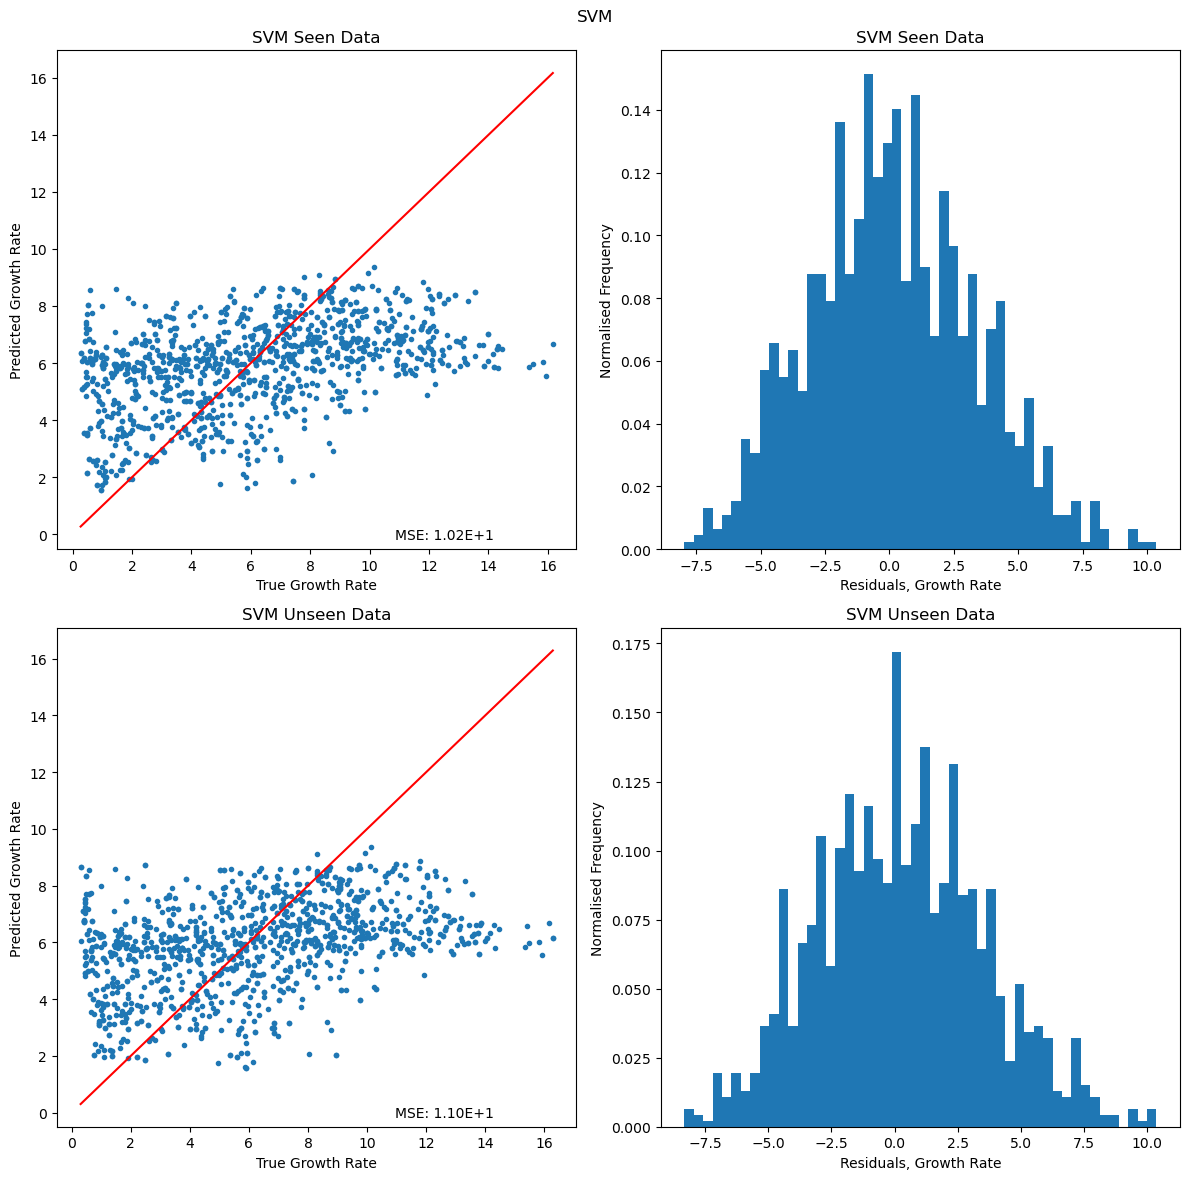

In [9]:
import matplotlib.pyplot as plt
from GENE_ML.gene_ml import visualise as vis
model_name = 'SVM'
ncol=2
nrow=2
size=6
fig_residuals, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow))
    
vis.residual_plot(ax1, fig_residuals, data_set.growthrate_train, growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')
vis.residual_hist(ax2, fig_residuals, data_set.growthrate_train, growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')

vis.residual_plot(ax3, fig_residuals, data_set.growthrate_test, growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')
vis.residual_hist(ax4, fig_residuals, data_set.growthrate_test, growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')

fig_residuals.suptitle('SVM')
fig_residuals.tight_layout()
fig_residuals.show()

# GPR 5000s_7p

In [21]:
import os
import matplotlib.pyplot as plt
from GENE_ML.gene_ml.dataset.ScanData import ScanData
# #data_set = ScanData('3560_3p', ssh_path='lumi:$out/ped2_safescan/scanfiles0012/scan.log', test_percentage=50)
# data_set = ScanData('3560_3p', test_percentage=50)

#imports
from GENE_ML.gene_ml.models.GPR import GPR
from GENE_ML.gene_ml import visualise as vis
from GENE_ML.gene_ml.results.results import Results

#numsamples_numparameters_model_testpercentage
results_gpr_name = 'results_5000s_7p_gpr_50tp' #
results_gpr = Results(results_gpr_name)

if os.path.exists(results_gpr.path):
    print('\nLOADING RESULTS FROM FILE\n')
    results_gpr = results_gpr.load()
    print(f'{results_gpr.name} IS LOADED')
else:
    print('\nCOMPUTING RESULTS\n')
    #Sampling already done, gene has been ran
    data_set = ScanData(name='5000s_7p', parser=parser, test_percentage=50)
    gpr = GPR()
    gpr.train(data_set.x_train, data_set.growthrate_train)
    gpr.tune_hypers(data_set.x_train, data_set.growthrate_train)

    results_gpr.growthrate_predict_seen, results_gpr.growthrate_predict_seen_errors = gpr.predict(data_set.x_train)
    results_gpr.growthrate_predict_unseen, results_gpr.growthrate_predict_unseen_errors = gpr.predict(data_set.x_test)

    results_gpr.save()


COMPUTING RESULTS

Initialising dataset

LOADING SCANLOG/S


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___6.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___15.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___18.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___5.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___8.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___9.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___11.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___10.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___14.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/scan___19.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/5000s_7p/s

 /opt/conda/envs/gene_ml/lib/python3.10/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /opt/conda/envs/gene_ml/lib/python3.10/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /opt/conda/envs/gene_ml/lib/python3.10/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


Optimization restart 1/3, f = -1120.7625791826579
Optimization restart 2/3, f = -1120.7625266603425
Optimization restart 3/3, f = -1120.762581102791
RESULTING HYPERS:
 
Name : GP regression
Objective : -1120.762581102791
Number of Parameters : 10
Number of Optimization Parameters : 10
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      16.159105490047388  |      +ve      |        
  rbf.lengthscale          |                    (8,)  |      +ve      |        
  Gaussian_noise.variance  |  1.6383407470208206e-17  |      +ve      |        


MAX 16.167 16.166999987788124
16.167
MAX 16.291 16.166999987788124
16.291


 /tmp/ipykernel_16583/269279542.py:20: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown


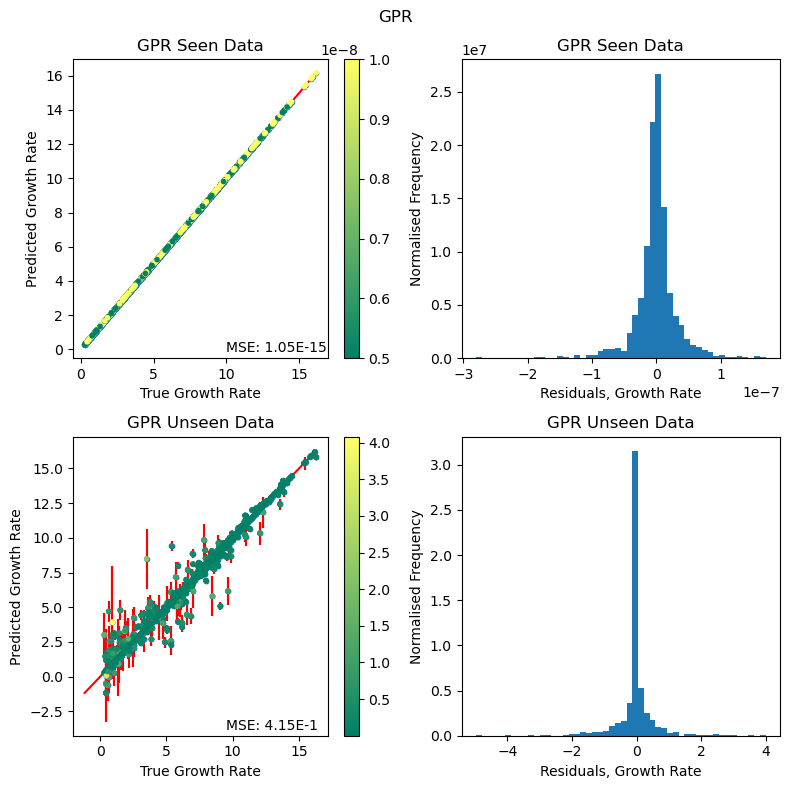

In [26]:
import matplotlib.pyplot as plt
from GENE_ML.gene_ml import visualise as vis

ncol=2
nrow=2
size=4
model_name = 'GPR'
fig_residuals, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow))
    
vis.residual_plot(ax1, fig_residuals, data_set.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data', y_pred_err=results_gpr.growthrate_predict_seen_errors)
vis.residual_hist(ax2, fig_residuals, data_set.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')

vis.residual_plot(ax3, fig_residuals, data_set.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data', y_pred_err=results_gpr.growthrate_predict_unseen_errors)
vis.residual_hist(ax4, fig_residuals, data_set.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')

# ax4.sharex(ax2)

fig_residuals.suptitle(model_name)
fig_residuals.tight_layout()
fig_residuals.show()
